# ANN with Mannual Feature Extraction

In the approach 2, from the based dataset new binary dataset was produce extracting the conventional features which can used to flag  the spam URLs. Then the dataset was fed into the custom Sequential ANN model and predict the outcome of the trained model.


# Setup Environment

In [ ]:
import pandas as pd
import gdown
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# File URL and extraction
file_url = "https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO"
output_zip = "spam.zip"
gdown.download(file_url, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("spam_files")
os.remove(output_zip)

# Load dataset
df = pd.read_csv('spam_files/url_spam_classification.csv')

Downloading...
From: https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO
To: /content/spam.zip
100%|██████████| 3.58M/3.58M [00:00<00:00, 25.0MB/s]


# Data Preprocessing

In [ ]:
# Convert is_spam to binary
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x == df['is_spam'].unique()[0] else 0)

# Feature extraction
df['len_url'] = df['url'].apply(lambda x: len(x))
df['contains_subscribe'] = df['url'].apply(lambda x: 1 if "subscribe" in x else 0)
df['contains_hash'] = df['url'].apply(lambda x: 1 if "#" in x else 0)
df['num_digits'] = df['url'].apply(lambda x: len("".join(_ for _ in x if _.isdigit())))
df['non_https'] = df['url'].apply(lambda x: 1 if "https" not in x else 0)  # Change to 'non_https'
df['num_words'] = df['url'].apply(lambda x: len(x.split("/")))
df['contains_http'] = df['url'].apply(lambda x: 1 if "http" in x else 0)
df['contains_special_chars'] = df['url'].apply(lambda x: 1 if any(char in x for char in ["$", "%", "&", "!", "@"]) else 0)
df['subdomain_count'] = df['url'].apply(lambda x: len(x.split(".")) - 2)  # Count subdomains

display(df)

# Select features and target
features = df.drop(columns=['url', 'is_spam'])
target = df['is_spam']




,url,is_spam,len_url,contains_subscribe,contains_hash,num_digits,non_https,num_words,contains_http,contains_special_chars,subdomain_count
0,https://briefingday.us8.list-manage.com/unsubs...,1,51,1,0,1,0,4,1,0,2
1,https://www.hvper.com/,1,22,0,0,0,0,4,1,0,1
2,https://briefingday.com/m/v4n3i4f3,1,34,0,0,4,0,5,1,0,0
3,https://briefingday.com/n/20200618/m#commentform,0,48,0,1,8,0,6,1,0,0
4,https://briefingday.com/fan,1,27,0,0,0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
148298,"https://cdn.substack.com/image/fetch/f_auto,q_...",1,223,0,0,52,0,7,1,1,5
148299,https://numlock.substack.com/subscribe,1,38,1,0,0,0,4,1,0,1
148300,https://docs.google.com/forms/d/e/1FAIpQLSfDLO...,1,99,0,0,11,0,8,1,0,1
148301,https://bookclub.substack.com/,1,30,0,0,0,0,4,1,0,1


# Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential # Import Sequential from Keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Modify the ANN architecture
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),  # Increase neurons
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 256)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,569 (178.00 KB)

 Trainable params: 44,673 (174.50 KB)

 Non-trainable params: 896 (3.50 KB)

# Train the Model

In [ ]:

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)  # Increase epochs



Epoch 1/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7756 - loss: 0.4962 - val_accuracy: 0.8220 - val_loss: 0.4127
Epoch 2/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8051 - loss: 0.4338 - val_accuracy: 0.8252 - val_loss: 0.3987
Epoch 3/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8145 - loss: 0.4178 - val_accuracy: 0.8344 - val_loss: 0.3852
Epoch 4/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8224 - loss: 0.4051 - val_accuracy: 0.8342 - val_loss: 0.3770
Epoch 5/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8245 - loss: 0.4014 - val_accuracy: 0.8417 - val_loss: 0.3699
Epoch 6/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8254 - loss: 0.3996 - val_accuracy: 0.8444 - val_loss: 0.3622
Epoch 7/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8293 - loss: 0.3928 - val_accuracy: 0.8462 - val_loss: 0.3643
Epoch 8/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8309 -

In [ ]:
# Evaluate the ANN model

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get unique class labels from y_test (or original target variable)
unique_classes = np.unique(y_test) # Assuming y_test contains the target labels

# Evaluate the ANN model
ann_pred = (model.predict(X_test) > 0.5).astype(int) # Ensure you are predicting on the entire X_test
ann_pred = np.squeeze(ann_pred) # Remove the extra dimension from ann_pred
print("\nArtificial Neural Network Report:")
print(classification_report(y_test, ann_pred, target_names=[f'Class {label}' for label in unique_classes]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ann_pred))

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

Artificial Neural Network Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.81      0.85     20185
     Class 1       0.83      0.91      0.87     20224

    accuracy                           0.86     40409
   macro avg       0.86      0.86      0.86     40409
weighted avg       0.86      0.86      0.86     40409

Confusion Matrix:
[[16341  3844]
 [ 1800 18424]]


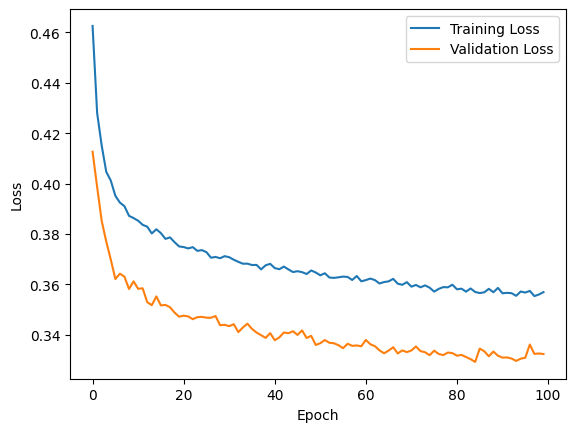

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure pred is calculated using the entire X_test dataset
pred = (model.predict(X_test) > 0.5).astype(int)
pred = np.squeeze(pred)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 0.8603281447202356
Precision: 0.8273756062511227
Recall: 0.910996835443038
F1-Score: 0.8671749976466159
ROC AUC: 0.86027919552682


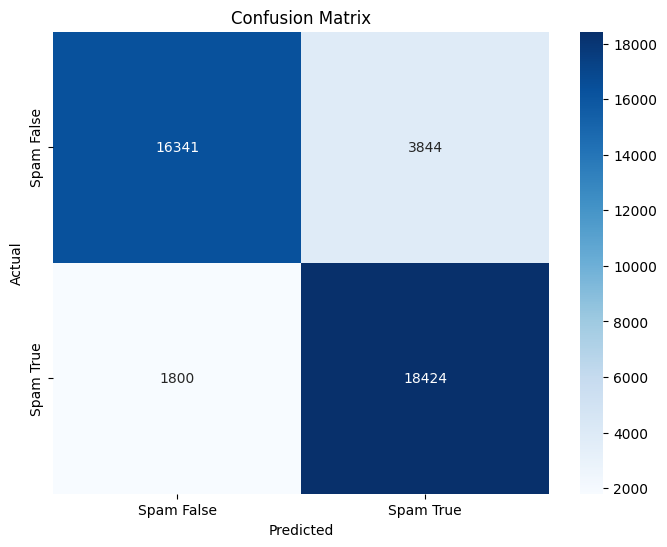

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Spam False', 'Spam True'], yticklabels=['Spam False', 'Spam True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Validate the test set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.56      0.83      0.67         6

    accuracy                           0.55        11
   macro avg       0.53      0.52      0.48        11
weighted avg       0.53      0.55      0.49        11

[[1 4]
 [1 5]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction Results on New Data:


,Link,Label,Predicted,Prediction Probability
0,https://briefingday.us8.list-manage.com/unsubs,1,1,0.980346
1,https://numlock.substack.com/subscribe,1,1,0.989917
2,https://briefingday.com/n/20200618/m#commentform,0,0,0.043125
3,https://www.youtube.com/,0,1,0.813759
4,https://www.google.com/,0,1,0.809605
5,https://hitha.substack.com/people/976632-hitha...,1,1,0.761250
6,https://us3.campaign-archive.com/,1,1,0.948822
7,"https://cdn.substack.com/image/fetch/f_auto,q_...",1,0,0.454011
8,http://tib.matthewclifford.com/issues/tib-131-...,1,1,0.543283
9,https://web.whatsapp.com/,0,1,0.824791


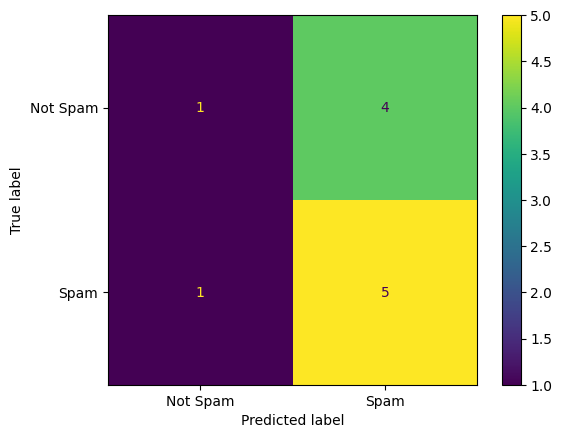

In [ ]:
df_test = pd.DataFrame({
    'Link': [
        'https://briefingday.us8.list-manage.com/unsubs',
        'https://numlock.substack.com/subscribe',
        'https://briefingday.com/n/20200618/m#commentform',
        'https://www.youtube.com/',
        'https://www.google.com/',
        'https://hitha.substack.com/people/976632-hitha-palepu',
        'https://us3.campaign-archive.com/',
        'https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fcd5914a8-e144-4812-8e41-67e295f05007_150x25.png',
        'http://tib.matthewclifford.com/issues/tib-131-how-smart-are-politicians-why-tech-needs-some-crazy-money-religious-fundamentalism-and-the-internet-and-more-276446',
        'https://web.whatsapp.com/',
        'https://outlook.office365.com/'
    ],
    'Label': [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
})


# Feature extraction
df_test['len_url'] = df_test['Link'].apply(lambda x: len(x))
df_test['contains_subscribe'] = df_test['Link'].apply(lambda x: 1 if "subscribe" in x else 0)
df_test['contains_hash'] = df_test['Link'].apply(lambda x: 1 if "#" in x else 0)
df_test['num_digits'] = df_test['Link'].apply(lambda x: len("".join(_ for _ in x if _.isdigit())))
df_test['non_https'] = df_test['Link'].apply(lambda x: 1 if "https" not in x else 0)
df_test['num_words'] = df_test['Link'].apply(lambda x: len(x.split("/")))
df_test['contains_http'] = df_test['Link'].apply(lambda x: 1 if "http" in x else 0)
df_test['contains_special_chars'] = df_test['Link'].apply(lambda x: 1 if any(char in x for char in ["$", "%", "&", "!", "@"]) else 0)
df_test['subdomain_count'] = df_test['Link'].apply(lambda x: len(x.split(".")) - 2)

# Select features
X_test = df_test.drop(columns=['Link', 'Label'])

# Scale features
X_test_scaled = scaler.transform(X_test)

# Make predictions
pred_test = (model.predict(X_test_scaled) > 0.5).astype(int)


# Evaluate the model
print(classification_report(df_test['Label'], pred_test))
print(confusion_matrix(df_test['Label'], pred_test))


# Make predictions with probabilities
pred_test_probs = model.predict(X_test_scaled)
pred_test = (pred_test_probs > 0.5).astype(int)

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Link': df_test['Link'],
    'Label': df_test['Label'],
    'Predicted': pred_test.flatten(),
    'Prediction Probability': pred_test_probs.flatten()
})

print("Prediction Results on New Data:")
display(results_df)


cm = confusion_matrix(df_test['Label'], pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot()
plt.show()

In [ ]:
import joblib

# # Save the model and vectorizer
joblib.dump(model, 'modelv2.pkl')



['modelv2.pkl']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/DeepLearningAssigment/MyDrive/modelv2.pkl'

Mounted at /content/drive


In [ ]:
loaded_model = joblib.load('modelv2.pkl')

In [ ]:
df_test = pd.DataFrame({
    'Link': [
        'https://briefingday.us8.list-manage.com/unsubs',
        'https://numlock.substack.com/subscribe',
        'https://briefingday.com/n/20200618/m#commentform',
        'https://www.youtube.com/',
        'https://www.google.com/',
        'https://hitha.substack.com/people/976632-hitha-palepu',
        'https://us3.campaign-archive.com/',
        'https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fcd5914a8-e144-4812-8e41-67e295f05007_150x25.png',
        'http://tib.matthewclifford.com/issues/tib-131-how-smart-are-politicians-why-tech-needs-some-crazy-money-religious-fundamentalism-and-the-internet-and-more-276446',
        'https://web.whatsapp.com/',
        'https://outlook.office365.com/'
    ],
    'Label': [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
})


# Feature extraction
df_test['len_url'] = df_test['Link'].apply(lambda x: len(x))
df_test['contains_subscribe'] = df_test['Link'].apply(lambda x: 1 if "subscribe" in x else 0)
df_test['contains_hash'] = df_test['Link'].apply(lambda x: 1 if "#" in x else 0)
df_test['num_digits'] = df_test['Link'].apply(lambda x: len("".join(_ for _ in x if _.isdigit())))
df_test['non_https'] = df_test['Link'].apply(lambda x: 1 if "https" not in x else 0)
df_test['num_words'] = df_test['Link'].apply(lambda x: len(x.split("/")))
df_test['contains_http'] = df_test['Link'].apply(lambda x: 1 if "http" in x else 0)
df_test['contains_special_chars'] = df_test['Link'].apply(lambda x: 1 if any(char in x for char in ["$", "%", "&", "!", "@"]) else 0)
df_test['subdomain_count'] = df_test['Link'].apply(lambda x: len(x.split(".")) - 2)

# Select features
X_Viva = df_test.drop(columns=['Link', 'Label'])

# Scale features
X_viva_scaled = scaler.transform(X_Viva)


In [ ]:
# predictions = (loaded_model.predict(X_viva_scaled) > 0.6).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


In [ ]:
# Make predictions with probabilities
pred_viva_probs = loaded_model.predict(X_viva_scaled)
pred_viva = (pred_viva_probs > 0.5).astype(int)

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Link': df_test['Link'],
    'Label': df_test['Label'],
    'Predicted': pred_viva.flatten(),
    'Prediction Probability': pred_viva_probs.flatten()
})

print("Prediction Results on New Data:")
display(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction Results on New Data:


,Link,Label,Predicted,Prediction Probability
0,https://briefingday.us8.list-manage.com/unsubs,1,1,0.980346
1,https://numlock.substack.com/subscribe,1,1,0.989917
2,https://briefingday.com/n/20200618/m#commentform,0,0,0.043125
3,https://www.youtube.com/,0,1,0.813759
4,https://www.google.com/,0,1,0.809605
5,https://hitha.substack.com/people/976632-hitha...,1,1,0.761250
6,https://us3.campaign-archive.com/,1,1,0.948822
7,"https://cdn.substack.com/image/fetch/f_auto,q_...",1,0,0.454011
8,http://tib.matthewclifford.com/issues/tib-131-...,1,1,0.543283
9,https://web.whatsapp.com/,0,1,0.824791
